In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as Layers

In [2]:
mnist = keras.datasets.mnist

(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
XtrainT = Xtrain.reshape((Xtrain.shape[0],
                          Xtrain.shape[1],
                          Xtrain.shape[2],
                          1))
XtestT = Xtest.reshape((Xtest.shape[0],
                        Xtest.shape[1],
                        Xtest.shape[2],
                        1))
ytrainT = ytrain
ytestT = ytest

XtrainM = Xtrain
XtestM = Xtest
ytrainM = ytrain
ytestM = ytest

print(XtrainT.shape)
print(XtestT.shape)
print(XtrainM.shape)
print(XtestM.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28)
(10000, 28, 28)


In [4]:
from sklearn.model_selection import train_test_split

XlearnT, XvalT, ylearnT, yvalT = train_test_split(XtrainT, ytrainT,
                                                  test_size = 1/6,
                                                  shuffle = True,
                                                  stratify = ytrainT,
                                                  random_state = 1234)
XlearnM, XvalM, ylearnM, yvalM = train_test_split(XtrainM, ytrainM,
                                                  test_size = 1/6,
                                                  shuffle = True,
                                                  stratify = ytrainM,
                                                  random_state = 1234)
print(XlearnT.shape)
print(XvalT.shape)
print(XtestT.shape)
print(XlearnM.shape)
print(XvalM.shape)
print(XtestM.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [5]:
inputLayer = Layers.Input(name = "main_input", 
                          shape = (XlearnM.shape[1], 
                                   XlearnM.shape[2]))

#encoder part
tempLayer = Layers.Flatten(name = "flatten")(inputLayer)
tempLayer = Layers.Dense(128, name = "first_enc_relu", activation = "relu")(tempLayer)
tempLayer = Layers.Dense(64, name = "second_enc_relu", activation = "relu")(tempLayer)
encoded = Layers.Dense(16, name = "bottleneck", activation = "relu")(tempLayer)

#decoder part
tempLayer = Layers.Dense(64, name = "first_dec_relu", activation = "relu")(encoded)
tempLayer = Layers.Dense(128, name = "second_dec_relu", activation = "relu")(tempLayer)
tempLayer = Layers.Dense(784, name = "dec_sigmoid", activation = "sigmoid")(tempLayer)
decoded = Layers.Reshape((28, 28), name = "reshape", input_shape = (784,))(tempLayer)

autoencoder_model = Model(inputs = inputLayer, outputs = decoded)
encoder_model = Model(inputs = inputLayer, outputs = encoded)

decoderInput = Layers.Input(name = "bottleneck_input",
                            shape = 16)
tempLayer = autoencoder_model.layers[5](decoderInput)
tempLayer = autoencoder_model.layers[6](tempLayer)
tempLayer = autoencoder_model.layers[7](tempLayer)
decoderOutput = autoencoder_model.layers[8](tempLayer)
decoder_model = Model(inputs = decoderInput, outputs = decoderOutput)

encoder_model.summary()
autoencoder_model.summary()
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 first_enc_relu (Dense)      (None, 128)               100480    
                                                                 
 second_enc_relu (Dense)     (None, 64)                8256      
                                                                 
 bottleneck (Dense)          (None, 16)                1040      
                                                                 
Total params: 109,776
Trainable params: 109,776
Non-trainable params: 0
_________________________________________________________________
Model: "model"
______________________________________

2022-08-07 12:56:16.824710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
autoencoder_model.get_layer("bottleneck").weights

[<tf.Variable 'bottleneck/kernel:0' shape=(64, 16) dtype=float32, numpy=
 array([[ 0.21798822, -0.1152149 ,  0.18200955, ...,  0.04271469,
          0.10917473, -0.2578864 ],
        [ 0.09559351, -0.16063836,  0.11778381, ...,  0.05985165,
         -0.21097198, -0.15395027],
        [ 0.12967286, -0.06794238, -0.08211593, ..., -0.20632452,
          0.26874232,  0.20559171],
        ...,
        [-0.09053509, -0.19798775,  0.1767677 , ..., -0.24140123,
          0.0072799 ,  0.18180093],
        [-0.10331534, -0.14860253,  0.15091437, ..., -0.19032326,
          0.27216965, -0.1736254 ],
        [-0.17343867, -0.09750113,  0.2693346 , ...,  0.12168446,
          0.00790548,  0.1713866 ]], dtype=float32)>,
 <tf.Variable 'bottleneck/bias:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>]

In [7]:
autoencoder_model.compile(loss = "mse", optimizer = "adam")

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                           patience = 3)
autoencoder_history = autoencoder_model.fit(XlearnM, XlearnM,
                                            epochs = 50,
                                            batch_size = 250, 
                                            verbose = 1,
                                            validation_data = (XvalM, XvalM),
                                            callbacks = [early_stop])

Epoch 1/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0696 - val_loss: 0.0435
Epoch 2/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0365 - val_loss: 0.0315
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0288 - val_loss: 0.0263
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0249 - val_loss: 0.0235
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0226 - val_loss: 0.0216
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0210 - val_loss: 0.0203
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 8/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 9/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0182 - val_loss: 0.0178
Epoch 10/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0175 - val_loss: 0.0173

In [9]:
np.sqrt(0.0139)

0.11789826122551596

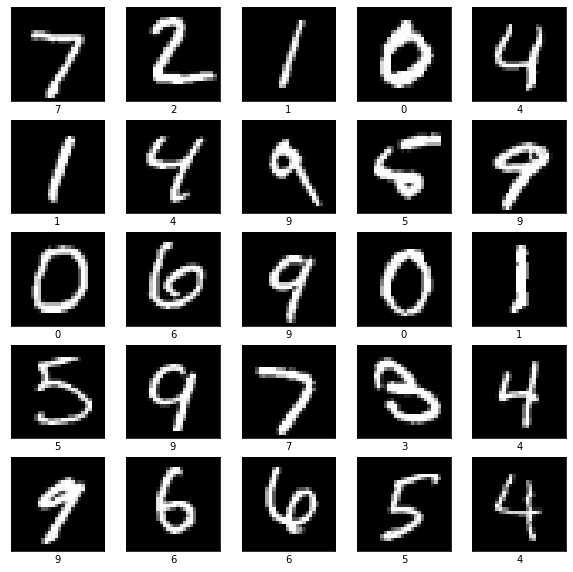

In [10]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(XtestM[i,:,:], cmap = plt.cm.gray)
    plt.xlabel(ytestM[i])
plt.show()

In [11]:
reconstructed = autoencoder_model.predict(XtestM[:25, :, :])

In [12]:
print(reconstructed.shape)

(25, 28, 28)


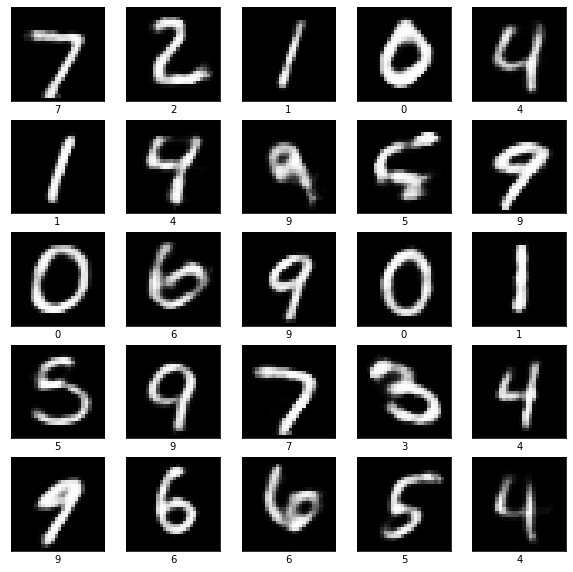

In [13]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(reconstructed[i,:,:], cmap = plt.cm.gray)
    plt.xlabel(ytestM[i])
plt.show()

In [14]:
# party A
compressed = encoder_model.predict(XtestM)
print(compressed.shape)

(10000, 16)


In [15]:
# party B
reconstructed = decoder_model.predict(compressed)
print(reconstructed.shape)

(10000, 28, 28)


In [16]:
a = autoencoder_model.get_layer("first_enc_relu").weights[0].numpy()[5, 5]
print(a)
b = encoder_model.get_layer("first_enc_relu").weights[0].numpy()[5, 5]
print(b)

-0.06809613
-0.06809613


In [17]:
a = autoencoder_model.get_layer("first_dec_relu").weights[0].numpy()[5, 5]
print(a)
b = decoder_model.get_layer("first_dec_relu").weights[0].numpy()[5, 5]
print(b)

-0.10334414
-0.10334414


In [18]:
inputLayer = Layers.Input(name = "main_input", 
                          shape = (XlearnT.shape[1], 
                                   XlearnT.shape[2],
                                   XlearnT.shape[3]))

#encoder part
tempLayer = Layers.Conv2D(16, 
                          kernel_size = (3, 3), 
                          name = "first_enc_relu", 
                          padding = "same",
                          activation = "relu")(inputLayer)
tempLayer = Layers.BatchNormalization()(tempLayer)
tempLayer = Layers.MaxPool2D((2, 2), padding = "same")(tempLayer)
tempLayer = Layers.Conv2D(32, 
                          kernel_size = (3, 3), 
                          name = "second_enc_relu", 
                          padding = "same",
                          activation = "relu")(tempLayer)
tempLayer = Layers.BatchNormalization()(tempLayer)
tempLayer = Layers.MaxPool2D((2, 2), padding = "same")(tempLayer)
shape_before_bottleneck = tempLayer.shape[1:]

tempLayer = Layers.Flatten()(tempLayer)

encoded = Layers.Dense(16, name = "bottleneck", activation = "relu")(tempLayer)

#decoder part
tempLayer = Layers.Dense(np.prod(shape_before_bottleneck),
                         activation = "relu")(encoded)
tempLayer = Layers.Reshape(shape_before_bottleneck)(tempLayer)

tempLayer = Layers.Conv2DTranspose(32, kernel_size = (3, 3),
                                   padding = "same", 
                                   activation = "relu",
                                   strides = 2)(tempLayer)
tempLayer = Layers.BatchNormalization()(tempLayer)
tempLayer = Layers.Conv2DTranspose(16, kernel_size = (3, 3),
                                   padding = "same", 
                                   activation = "relu",
                                   strides = 2)(tempLayer)
tempLayer = Layers.BatchNormalization()(tempLayer)
decoded = Layers.Conv2D(1, (3, 3),
                        activation = "sigmoid",
                        padding = "same")(tempLayer)

autoencoder_model = Model(inputs = inputLayer, outputs = decoded)
encoder_model = Model(inputs = inputLayer, outputs = encoded)

decoderInput = Layers.Input(name = "bottleneck_input",
                            shape = 16)
tempLayer = autoencoder_model.layers[9](decoderInput)
tempLayer = autoencoder_model.layers[10](tempLayer)
tempLayer = autoencoder_model.layers[11](tempLayer)
tempLayer = autoencoder_model.layers[12](tempLayer)
tempLayer = autoencoder_model.layers[13](tempLayer)
tempLayer = autoencoder_model.layers[14](tempLayer)
decoderOutput = autoencoder_model.layers[15](tempLayer)
decoder_model = Model(inputs = decoderInput, outputs = decoderOutput)

encoder_model.summary()
autoencoder_model.summary()
decoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 first_enc_relu (Conv2D)     (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 second_enc_relu (Conv2D)    (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128 

In [19]:
autoencoder_model.compile(loss = "mse", optimizer = "adam")
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                           patience = 3)
autoencoder_history = autoencoder_model.fit(XlearnT, XlearnT,
                                            epochs = 50,
                                            batch_size = 250, 
                                            verbose = 1,
                                            validation_data = (XvalT, XvalT),
                                            callbacks = [early_stop])

Epoch 1/50
200/200 [==============================] - 31s 152ms/step - loss: 0.0712 - val_loss: 0.0877
Epoch 2/50
200/200 [==============================] - 36s 182ms/step - loss: 0.0249 - val_loss: 0.0389
Epoch 3/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0189 - val_loss: 0.0182
Epoch 4/50
200/200 [==============================] - 31s 153ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 5/50
200/200 [==============================] - 31s 153ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 6/50
200/200 [==============================] - 30s 150ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 7/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 8/50
200/200 [==============================] - 30s 151ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 9/50
200/200 [==============================] - 31s 157ms/step - loss: 0.0138 - val_loss: 0.0142
Epoch 10/50
200/200 [==============================] - 33s 165ms/step - l

(25, 28, 28, 1)


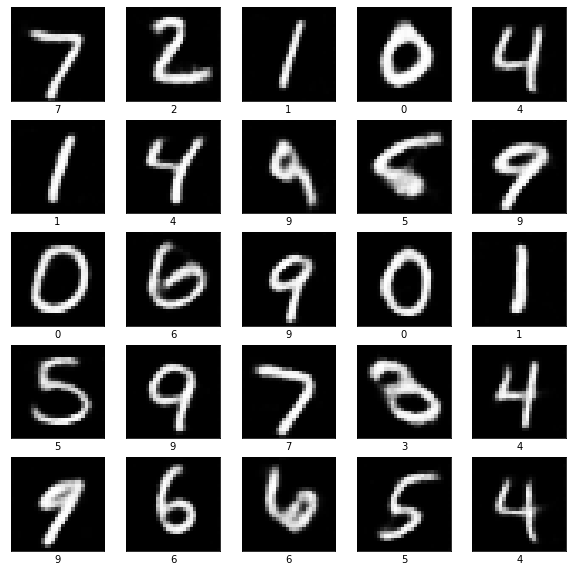

In [20]:
reconstructed = autoencoder_model.predict(XtestT[:25, :, :, :])
print(reconstructed.shape)
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(reconstructed[i,:,:,:], cmap = plt.cm.gray)
    plt.xlabel(ytestT[i])
plt.show()

In [21]:
# party A
compressed = encoder_model.predict(XtestT)
print(compressed.shape)
# party B
reconstructed = decoder_model.predict(compressed)
print(reconstructed.shape)

(10000, 16)
(10000, 28, 28, 1)


In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)

tsne.fit(compressed)

/Users/mehmetgonen/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mehmetgonen/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE()

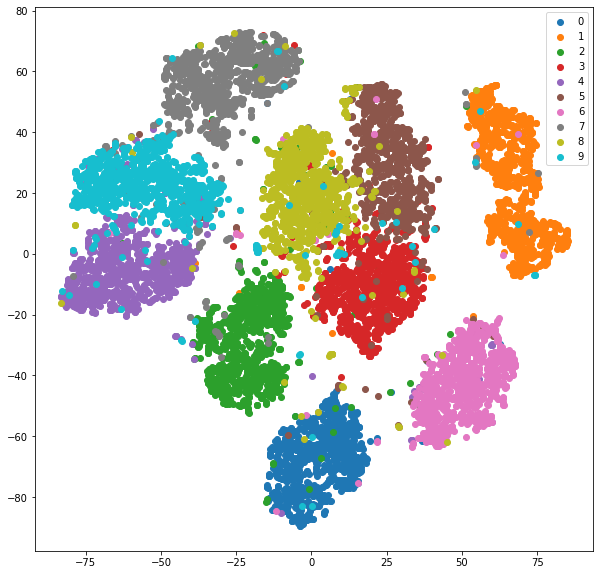

In [23]:
plt.figure(figsize = (10, 10))
for c in range(10):
    indices = np.where(ytestT == c)[0]
    plt.scatter(tsne.embedding_[indices, 0],
                tsne.embedding_[indices, 1],
                label = c)
plt.legend()
plt.show()

In [24]:
from keras.applications import vgg19, inception_v3, mobilenet
vgg19_model = vgg19.VGG19(include_top = False)

mobilenet_model = mobilenet.MobileNet(include_top = False)
#keras.utils.plot_model(vgg19_model, show_shapes = True)

inception_v3_model = inception_v3.InceptionV3(include_top = False)
#keras.utils.plot_model(inception_v3_model, show_shapes = True)

#tf.keras.utils.load_img()
print(len(inception_v3_model.layers))

print(inception_v3_model.layers[310].trainable)

#inception_v3.preprocess_input()
#inception_v3_model.predict() #2048-dimensional vectors

311
True
